# Machine Learning - SS18

Ludwig-Maximilians-Universität München
* Lecturer: Prof. Dr. Volker Tresp
* Assistant: Christian Frey, Julian Busch
* Tutor: Changkun Ou <hi@changkun.us\>

# 3rd Tutorial - 04/26/18

In this tutorial, we want to give you a short introduction in TensorFlow and some insights in the basic usage of some common function calls.

## What is  TensorFlow?
<it>TensorFlow</it> is a powerful open source sfotware library for numerial computation, particularly optimized and fine-tuned for large-scale Machine Learning problems.

The basic principle of TensorFlow is as follows: first, we define in python a graph of computations which will be executed. TensorFlow then takes that graph and runs it efficiently using optimized C++ code.

To deal also with large-scale problems, the graph is broken up into several chunks such that they can be computed in parallel across multiple CPUs or GPUs. This makes it possible for TensorFlow to run and train a network with millions of parameters on a training set composed of billions of instances with millions of features each. 

## Installation

Assuming you installed Jupyter and Scikit-learn, you can simply use <em>pip install</em> to install TensorFlow. If you created an isolated environment using <it>virtualenv</it>, you first need to activate the environment for which you would like to install TensforFlow.

- cd \$your_env // path to your working directory
- source env/bin/activate

Next, install TensorFlow:
- pip3 install --upgrade tensorflow

Side note: if you would like to have GPU support, youe need to install tensorflow-gpu instead of tensorflow. For our basic introduction no GPU support is needed.

## Basic Arithmetic
First we execute some elementary TensorFlow computational graphs.

#### Load dependencies

In [1]:
import tensorflow as tf

/root/notebook/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Usage of tf.Variables
In the  following cell, we define two Variables and a function. Most important to understand is that the functions <em>fnc</em> is not caluclated by the following three lines. It just created a computation graph. In fact, even the variables are not initialized yet. 

In [2]:
x1 = tf.Variable(3, name="x1")
x2 = tf.Variable(6, name="x2")
fnc = x1*2*x2 + x2

### What is a session in TensorFlow?

To actually execute the computation, what we need to do is to open a TensforFlow $session$. Within that, we can initialize the variables and evaluate <em>fnc</em>. A TensorFlow $session$ handles the distribution of operations onto computational units such as CPUs and GPUs and runs them. In addition to that, it keeps the variables values stored. In the following cell, we create a session, initialize the variables and evaluate the function <em>fnc</em>.

In [3]:
session = tf.Session()
session.run(x1.initializer)
session.run(x2.initializer)
result = session.run(fnc)
print (result)

42


In the end, the session can be closed which frees up any resources which have been used in that session.

In [4]:
session.close()

A more handy way of generating a session without having to repeat $sess.run()$ all the time is by using the following structure. Notice that at the end of the block the session is also automatically closed. 

In [5]:
with tf.Session() as session:
    x1.initializer.run()
    x2.initializer.run()
    result=fnc.eval()

One further optimization for this kind of code is to use a global initializer for initializing all variables. Therefore we can use the global_varaibles_initializer() function. Again, this does not perform the initialization imediately, but rather creates a node in the computation graph that indicates that all variables will be initialized.

In [6]:
init = tf.global_variables_initializer()

with tf.Session() as session:
    init.run()
    result = fnc.eval()

#### Usage of tf.placeholders

In case that our values are changing during our computation, we need to specify placeholder nodes instead of variables. These nodes are different as they don't actually perform any computation, they just output the data you tell them to output at runtime. They are typically used to pass the training data to TensorFlow during training (e.g., mini-batches). If at runtime the values for a placeholder is not specified TensorFlow throws an exception. The next cell shows how we can easily create placeholders having a specific type being attached in the parameter list.

In [7]:
y1 = tf.placeholder(tf.float32)
y2 = tf.placeholder(tf.float32)

Let's say, we want to add/multiply those two values being stored in the placeholders $y1$ and $y2$. Therefore, we take usage of two tensorflow operations $tf.add(\cdot,\cdot)$ and $tf.multiply(\cdot,\cdot)$

In [8]:
sum_op = tf.add(y1, y2)
product_op = tf.multiply(y1, y2)

Finally, we can again evaluate the two operations within a session. We use the feed_dict of the $session.run(\cdot)$ to feed the data to our code. We specify the values by a key being the reference to our placheolder node and as values the actual value of the placeholder. 

In [9]:
with tf.Session() as session:
    sum_result = session.run(sum_op, feed_dict={y1: 36.0, y2: 6.0})
    product_result = session.run(product_op, feed_dict={y1: 6.0, y2: 21.0})

In [10]:
print (sum_result)
print (product_result)

42.0
126.0


#### basic arrray arithemtic using tf.placeholders

When we create a placeholer node we can optionally also specify its shape, if there is need to do that. If the dimension of the placeholder is not given (None), then it means that the placeholder is of "any size". The following cell show that we can also feed arrays to our two placeholders $y1$ and $y2$.

In [11]:
with tf.Session() as session:
    sum_result = session.run(sum_op, feed_dict={y1: [6.0, 4.0, 2.0], y2: [3, 2, 1.0]})
    product_result = session.run(product_op, feed_dict={y1: [2.0, 4.0], y2: 0.5})

In [12]:
print (sum_result)
print (product_result)

[9. 6. 3.]
[1. 2.]


## Linear Regression in TensorFlow

In this part, we want to use TensorFlow for a simple linear regression problem. The prediction of a linear regression model can be formulated as:

$$
\hat{y} = h_\theta (\mathbf{x}) = \theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n = \theta^{T} \cdot \mathbf{x}
$$

, where $\hat{y}$ is the predicted value, $n$ the number of features and $\theta_j$ is the $j$-th model parameter.
To measure how well (or poorly) the model fits the training data we can use the Mean Square Error. Hence, our goal is to find a value of $\theta$ that minimizes the MSE.

$$
MSE (\mathbf{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T} \cdot x^i - y^i)^2
$$


In the following, we use a dataset of the California Housing Prices. In order to get a feeling for the dataset, we will describe it shortly in the upcoming cells.

### California Housing Prices - Dataset - 

First, we load the dataset via the sklearn library and store it in a pandas dataframe. Notice that we will work on the dataset without any preprocessing steps for cleaning the data. We just take it as it is as the purpose of this Notebook is to show the functionality of TensorFlow. 

** Short note on the library Pandas ** 

Pandas stands for "Python Data Analysis Library. It is one library helping in analyzing data with Python and it is one of the most preferred and widely used tools in data manipulation. Pandas is open source and free to use. One of the most important features of pandas is the usage of dataframes which creates a Python object with rows and columns that is in its structure similar to what we use also as .csv/.tsv files or in standard SQL DBs. The dataframes help and make it much easier to work with data compared to working with lists and/or dictionaries through for-loops or list comprehensions. Here, we will again concentrate on some basic tools being provided by pandas!

#### Load data to a pandas dataframe

In [13]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()
df_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
df_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### Get a short decription of the dataset

The dataset contains 8 features being the "median income", "house age", "average number of rooms", "average number of bedrooms", "population", "average occupancy", "longitude" and "latitude". The function describe() generates a statistical overview over the dataset.

In [14]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


#### Get further information of the dataset
We can also print the types of the features and the numbe of entries by calling the info() function of a dataframe.

In [15]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
MedInc        20640 non-null float64
HouseAge      20640 non-null float64
AveRooms      20640 non-null float64
AveBedrms     20640 non-null float64
Population    20640 non-null float64
AveOccup      20640 non-null float64
Latitude      20640 non-null float64
Longitude     20640 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


#### plot Features of the dataset as histograms

Next, we can simply plot a statistical summerization of the distribution of the features by histograms. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f934807e278>,
      dtype=object)

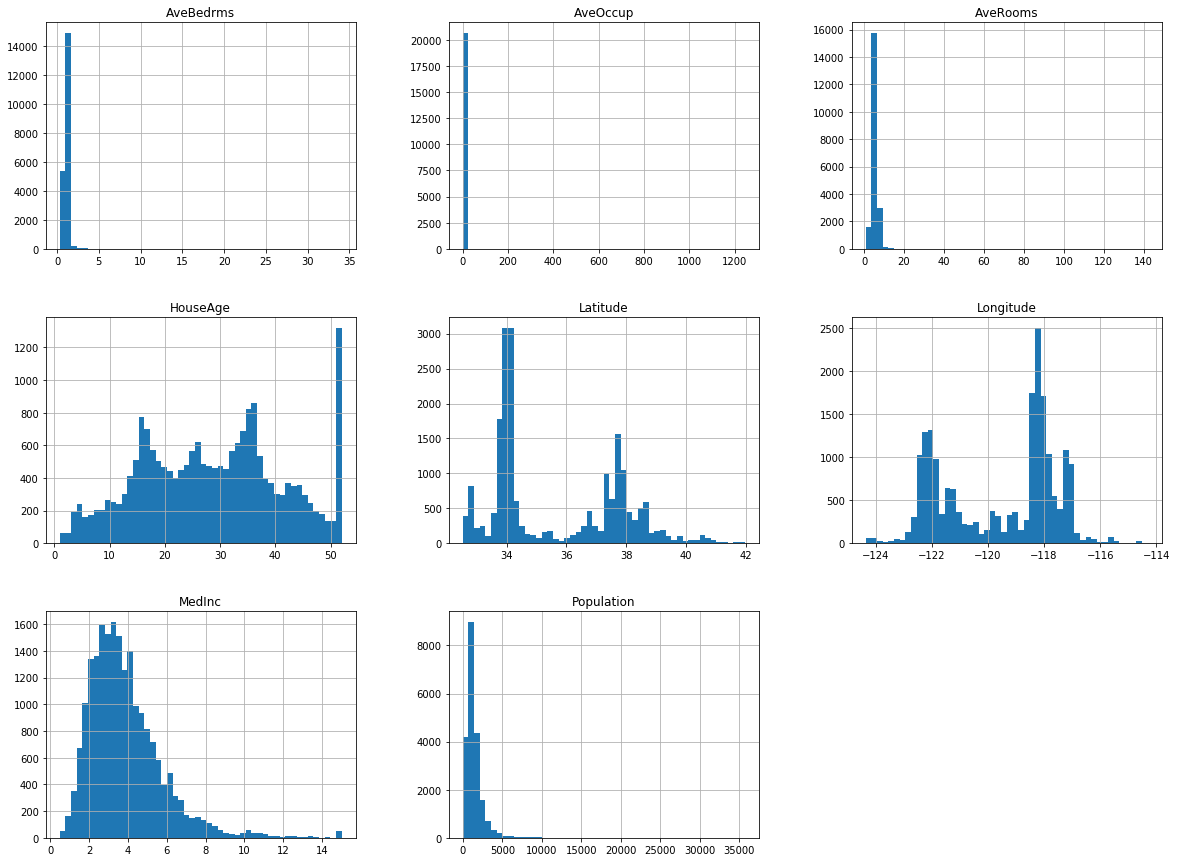

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
df_housing.hist(bins=50, figsize=(20,15))

#### Plot values as scatter plot - a deeper insight

We can also use the plot() function of dataframes to plot some features. Here, we will use the "latitude" and "longitude" information of the dataset to plot them on a 2D Grid. The size of the dots gives us additional information about the population. If we want to encode another feature of the dataset, we can use a color encoding, here, we use the median income for this additional dimension.

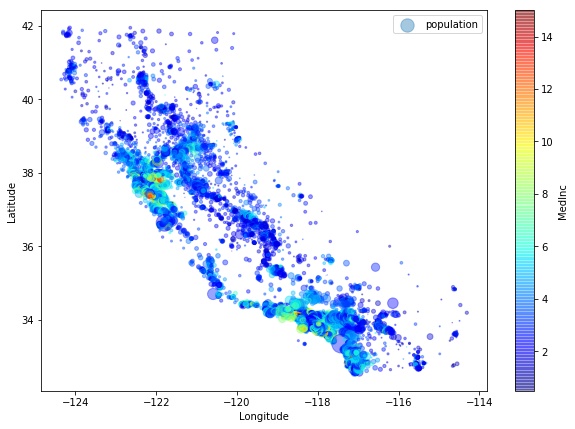

In [17]:
df_housing.plot.scatter(x="Longitude", y="Latitude", alpha=0.4,
    s=df_housing["Population"]/100.0, label="population", figsize=(10,7),
    c="MedInc", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True,
    sharex=False)

### Linear Regression using Normal Equation

Now, as we know what the dataset of California housing prices is all about, we will implement a linear regression model for this dataset in TensorFlow.

First, we solve the linear regression problem on the california housing data using the normal equation, which is given by:
$$
(X^{t} \cdot X)^{-1} \cdot X^{t} \cdot Y
$$
, where $M^{t}$ denotes the transpose of a Matrix $M$ and $M^{-1}$ denotes the (pseudo-)inverse of the matrix $M$.

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

# this retrieves us the information of the california housing dataset 
# in a numpy array
housing = fetch_california_housing()
# we get the dimension of the dataset (20640 entries with 8 features for each row)
m, n = housing.data.shape
# we add the bias term to the design matrix
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

# define the X and Y matrices as constants
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

# define the normal equation as computational graph in tf
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

# create a session and evaluate theta
with tf.Session() as sess:
    theta_value = theta.eval()

#### Linear Regression using Gradient Descent

Next, we will implement it, but rather than using the normal equation, we will use gradient descent to get our theta.

#### Computing the gradients manually

First we will use the standardscaler of sklearn to get a normalized dataset for the gradient descent. 

In [19]:
from sklearn.preprocessing import StandardScaler
#define the StandardScaler
scaler = StandardScaler()
# apply the standardscaler to the CA housing data
scaled_housing_data = scaler.fit_transform(housing.data)
# add the bias term
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [20]:
# define the number of epochs and the learning rate
n_epochs = 1000
learning_rate = 0.01

# construct the matrices X and Y
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
# define the weights of the regression model
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# define the computation of the predicted v values
y_pred = tf.matmul(X, theta, name="predictions")
# define the error
error = y_pred - y
# define the mean squared error of the predicted values and the real values
mse = tf.reduce_mean(tf.square(error), name="mse")
# manually describe the description of the gradients
gradients = 2/m * tf.matmul(tf.transpose(X), error)
# define the training operation
training_op = tf.assign(theta, theta - learning_rate * gradients)

# define the global initializer
init = tf.global_variables_initializer()

# create a session and run the training operation
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.53737885
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293705


#### Using automatic differentiation
Instead of defining the gradient manually, we can also use a function in tensorflow which approximates the gradients. The rest stays the same.

In [21]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

# automatic differentiation
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.54228795
Epoch 600 MSE = 0.5373789
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293704
Best theta:
[[ 2.06855249e+00]
 [ 7.74078071e-01]
 [ 1.31192386e-01]
 [-1.17845066e-01]
 [ 1.64778143e-01]
 [ 7.44078017e-04]
 [-3.91945094e-02]
 [-8.61356676e-01]
 [-8.23479772e-01]]


#### Using GradientDescentOptimizer

Another way of implementing the linear regression problem is to use the GradientDescentOptimizer of TensorFlow. For that, we say that we have the MSE as our evaluation function which is optimized (towards a small values) via the GradientDescentOptimizer.

In [22]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

# get instance of the GradientDescentOptimizer and set the learning rate
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# define the training operation
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

# create a session and evaluate the training_operation
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.54228795
Epoch 600 MSE = 0.5373789
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293704
Best theta:
[[ 2.06855249e+00]
 [ 7.74078071e-01]
 [ 1.31192386e-01]
 [-1.17845066e-01]
 [ 1.64778143e-01]
 [ 7.44078017e-04]
 [-3.91945094e-02]
 [-8.61356676e-01]
 [-8.23479772e-01]]


# End of the TensorFlow introduction